Dataset - https://www.kaggle.com/ted8080/house-prices-and-images-socal?select=socal2

In [1]:
from os.path import isfile, join
import pandas as pd
import numpy as np
import cv2
from utils import *
from sklearn.utils import resample

df = pd.read_csv("data/houses/socal2.csv")
df.head()

,image_id,street,citi,n_citi,bed,bath,sqft,price
0,0,1317 Van Buren Avenue,"Salton City, CA",317,3,2.0,1560,201900
1,1,124 C Street W,"Brawley, CA",48,3,2.0,713,228500
2,2,2304 Clark Road,"Imperial, CA",152,3,1.0,800,273950
3,3,755 Brawley Avenue,"Brawley, CA",48,3,1.0,1082,350000
4,4,2207 R Carrillo Court,"Calexico, CA",55,4,3.0,2547,385100


<AxesSubplot:>

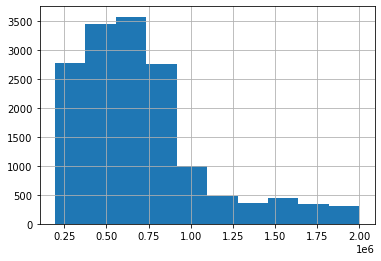

In [2]:
df.price.hist()

In [13]:
def load_dataset(df, images_path="data/houses/images", size=(32,32), gray_scale=False):
    images = []
    prices = []
    for _,row in df.iterrows():
        img_id = row.image_id
        prices.append(row.price)
        
        img = cv2.imread(join(images_path, f"{img_id}.jpg"))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if gray_scale else cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(cv2.resize(img, size))

    print(f"{len(images)} imagens carregadas")
    return np.array(images), np.array(prices)

size = (64,64)
gray_scale = True
images, prices = load_dataset(df, size=size, gray_scale=gray_scale)
if gray_scale:
    plt.gray()

15474 imagens carregadas


<Figure size 432x288 with 0 Axes>

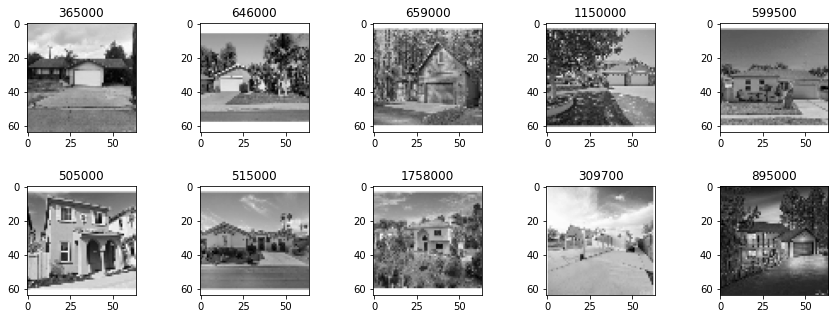

In [14]:
num_samples = 10
samples = resample(images, prices, n_samples=num_samples, replace=False)

plot_images(samples[0], labels=samples[1], rows=2)

In [15]:
from sklearn.model_selection import train_test_split

X = images_to_2d(images)
Y = prices

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [16]:
from models import PPCA
ppca = PPCA(200)
ppca.fit(X_train)

z = ppca.project(X_train)
x = ppca.reconstruct(z)

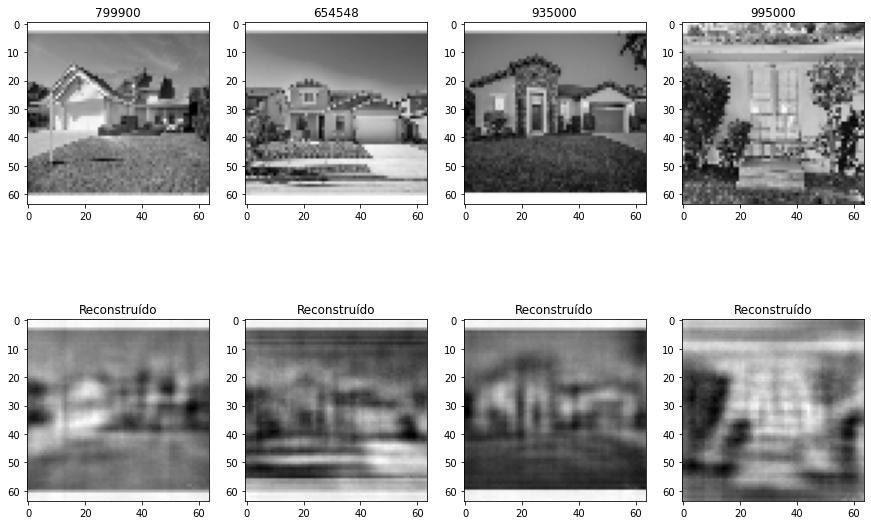

In [17]:
from sklearn.utils import resample

num_samples = 4
samples = resample(X_test, Y_test, n_samples=num_samples, replace=False)

fig = plt.figure(figsize=(15,10))
for n, (img, label) in enumerate(zip(samples[0], samples[1])):
    reconstruct = ppca.reconstruct(ppca.project(img))
    
    plt.subplot(2, num_samples, n+1)
    plt.title(label)
    plt.imshow(vector_to_image(img, size))
    
    plt.subplot(2, num_samples, n+num_samples+1)
    plt.title("Reconstruído")
    plt.imshow(vector_to_image(reconstruct, size))
    
plt.show()

In [18]:
from scipy.stats import multivariate_normal

identity = lambda x: x

def add_bias_parameter(x):
    '''Adiciona os termos independentes (parâmetro bias) aos dados'''
    return np.concatenate([np.ones(x.shape), x], axis=1)

class BayesianLinearRegression():
    
    def __init__(self, basis_function = add_bias_parameter):
        self.basis_function = basis_function
    
    def fit(self, x, Y, alpha = 2, beta = 25):
        
        self.beta = beta
        
        X = self.basis_function(x)
        var_inv = alpha*np.eye(X.shape[1]) + beta*X.T.dot(X)
        var = np.linalg.inv(var_inv)
        mean = beta * var.dot(X.T).dot(Y)
        
        self.mean = mean
        self.var = var
        
    def predict(self, x, return_var = False):
        X = self.basis_function(x)
        
        y = X.dot(self.mean)
        
        if return_var:
            var = (1 / self.beta) + np.sum(X.dot(self.var) * X, axis = 1)
            return y, var
        else:
            return y

Erro quadrado médio: 378505.9068921086


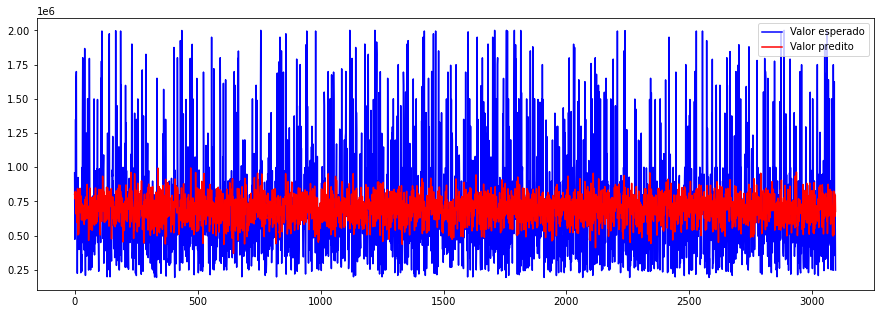

In [19]:
from sklearn.metrics import mean_squared_error

model = BayesianLinearRegression()
model.fit(z, Y_train, alpha=100, beta=100)

predictions = model.predict(ppca.project(X_test))

plt.figure(figsize=(15,5))
plt.plot(Y_test, c='b', label="Valor esperado")
plt.plot(predictions, c='r', label="Valor predito")

print(f"Erro quadrado médio: {mean_squared_error(Y_test, predictions, squared=False)}")

plt.legend()

Erro quadrado médio: 378507.3510974641


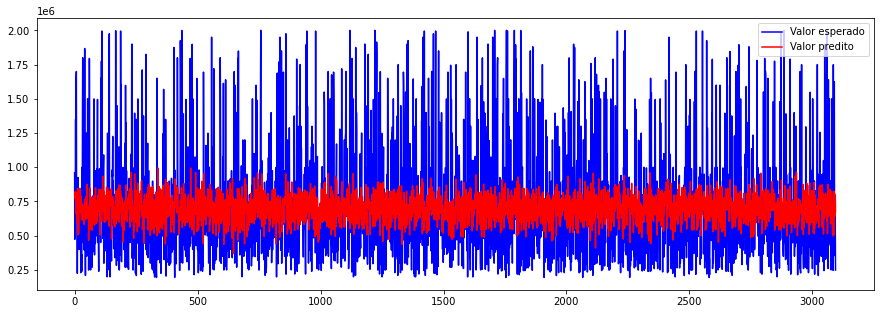

In [20]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(z, Y_train)

predictions = model.predict(ppca.project(X_test))

plt.figure(figsize=(15,5))
plt.plot(Y_test, c='b', label="Valor esperado")
plt.plot(predictions, c='r', label="Valor predito")

plt.legend()

print(f"Erro quadrado médio: {mean_squared_error(Y_test, predictions, squared=False)}")